# Shapley/ Interpretability

Resources: 
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

Materials by Patrick Hall:
https://github.com/jphall663/interpretable_machine_learning_with_python
https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/debugging_resid_analysis_redux.ipynb   
Decision tree plotting: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb


## Preparation

Use dataset provided in the eLearning

In [1]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

C:\Users\monta\AppData\Local\Temp\ipykernel_14648\3021516139.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))



# plotting ###########
import matplotlib.pyplot as plt                                   # general plotting
from matplotlib.lines import Line2D                               # necessary for custom legends
import seaborn as sns                                             # facet grid for residuals
from mpl_toolkits import mplot3d                                  # 3-D scatterplots
import matplotlib; matplotlib.rcParams.update({'font.size': 15})  # set legible font size#Extend cell width

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from C:\Users\monta\OneDrive\Desktop\BUAN_AML\ml-spring-2022\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\monta\AppData\Local\Temp\tmp_4rtnnv2
  JVM stdout: C:\Users\monta\AppData\Local\Temp\tmp_4rtnnv2\h2o_monta_started_from_python.out
  JVM stderr: C:\Users\monta\AppData\Local\Temp\tmp_4rtnnv2\h2o_monta_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,4 months and 3 days !!!
H2O_cluster_name:,H2O_from_python_monta_mrvl0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


### Load data

In [4]:
train = h2o.import_file('./Car_Prices_Poland_train.csv')
test = h2o.import_file('./Car_Prices_Poland_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
train.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
opel,insignia,gen-a-2008-2017,2009,106125,1796,Gasoline,CzÄ™stochowa,ÅšlÄ…skie,25000
skoda,fabia,gen-ii-2007,2010,207000,1200,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900
opel,insignia,gen-a-2008-2017,2013,195000,1956,Diesel,Ruda ÅšlÄ…ska,ÅšlÄ…skie,24598
audi,a4,gen-b8-2007-2015,2012,280000,1968,Diesel,BiaÅ‚ystok,Podlaskie,41900
citroen,c4-picasso,gen-ii-2013-c4-picasso,2014,122200,1560,Diesel,Dziemionna,Kujawsko-pomorskie,39500


In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (88445, 10)
Test shape: (29482, 10)


In [7]:
train.describe()

Rows:88445
Cols:10




,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1964.0,0.0,0.0,,,,500.0
mean,,,,2012.9334275538463,140832.01954887222,1812.3419074000788,,,,70347.49990389508
maxs,,,,2022.0,2800000.0,7600.0,,,,2399900.0
sigma,,,,5.684015918888913,92510.79953360025,646.7315007474649,,,,85275.90175596686
zeros,,,,0,283,936,,,,0
missing,0,0,22551,0,0,0,0,0,0,0
0,opel,insignia,gen-a-2008-2017,2009.0,106125.0,1796.0,Gasoline,CzÄ™stochowa,ÅšlÄ…skie,25000.0
1,skoda,fabia,gen-ii-2007,2010.0,207000.0,1200.0,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900.0
2,opel,insignia,gen-a-2008-2017,2013.0,195000.0,1956.0,Diesel,Ruda ÅšlÄ…ska,ÅšlÄ…skie,24598.0


In [8]:
# Choose which columns to encode
cat_columns = ["year","mark","model","generation_name","fuel","city","province"]
response = "price"

train[cat_columns] = train[cat_columns].asfactor()

## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='MAE',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [9]:
from h2o.estimators import H2OGradientBoostingEstimator
predictors_gbm = train.columns
predictors_gbm.remove(response)

gbm_model = H2OGradientBoostingEstimator(nfolds=5,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='MAE',
                                         seed=1234,
                                         keep_cross_validation_predictions = False)

gbm_model.train(x=predictors_gbm, y=response, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1651554215654_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,293.0,293.0,196090.0,5.0,5.0,5.0,9.0,32.0,18.255972




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 251922480.86022365
RMSE: 15872.066055187133
MAE: 7472.131577821829
RMSLE: 0.18135349901490003
Mean Residual Deviance: 251922480.86022365

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 426111054.40248585
RMSE: 20642.457566929523
MAE: 8549.64560884716
RMSLE: NaN
Mean Residual Deviance: 426111054.40248585

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,8.549647e+03,1.629994e+02,8.406591e+03,8.377341e+03,8.770862e+03,8.633817e+03,8.559626e+03
1,mean_residual_deviance,4.263252e+08,6.605607e+07,4.801996e+08,3.883372e+08,3.330348e+08,4.384821e+08,4.915723e+08
2,mse,4.263252e+08,6.605607e+07,4.801996e+08,3.883372e+08,3.330348e+08,4.384821e+08,4.915723e+08
3,r2,9.414850e-01,8.112592e-03,9.344333e-01,9.468375e-01,9.527395e-01,9.392133e-01,9.342011e-01
4,residual_deviance,4.263252e+08,6.605607e+07,4.801996e+08,3.883372e+08,3.330348e+08,4.384821e+08,4.915723e+08
5,rmse,2.059607e+04,1.630558e+03,2.191346e+04,1.970627e+04,1.824924e+04,2.093997e+04,2.217143e+04
6,rmsle,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-05-03 00:04:09,30.012 sec,0.0,85275.419670,54099.707244,7.271897e+09
1,,2022-05-03 00:04:10,30.186 sec,1.0,77851.464831,49180.507079,6.060851e+09
2,,2022-05-03 00:04:10,30.233 sec,2.0,71172.604110,44686.902110,5.065540e+09
3,,2022-05-03 00:04:10,30.249 sec,3.0,65252.710534,40694.908502,4.257916e+09
4,,2022-05-03 00:04:10,30.280 sec,4.0,59919.388132,37050.384252,3.590333e+09
5,,2022-05-03 00:04:10,30.296 sec,5.0,55216.669077,33840.285935,3.048881e+09
6,,2022-05-03 00:04:10,30.328 sec,6.0,50997.773760,30924.910597,2.600773e+09
7,,2022-05-03 00:04:10,30.336 sec,7.0,47301.103038,28349.832193,2.237394e+09
8,,2022-05-03 00:04:10,30.369 sec,8.0,43912.105631,26049.318886,1.928273e+09
9,,2022-05-03 00:04:10,30.386 sec,9.0,41020.744540,24032.314928,1.682701e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,1.397830e+15,1.000000,0.427763
1,year,1.363777e+15,0.975639,0.417342
2,generation_name,2.272500e+14,0.162573,0.069543
3,vol_engine,1.450150e+14,0.103743,0.044377
4,mileage,1.055651e+14,0.075521,0.032305
5,province,1.733796e+13,0.012403,0.005306
6,fuel,7.687174e+12,0.005499,0.002352
7,city,3.166573e+12,0.002265,0.000969
8,mark,1.383878e+11,0.000099,0.000042


In [10]:
test[cat_columns] = test[cat_columns].asfactor()
perf = gbm_model.model_performance(test) ### Model performance.
print(perf)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 343868977.75297624
RMSE: 18543.70453153782
MAE: 8277.501519511672
RMSLE: NaN
Mean Residual Deviance: 343868977.75297624



## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most important feature?
- Can you tell how feature is impacting (direction) probability? 

### The most important feature is Year followed by model closely. We can see the probability impact but not the direction, so no.

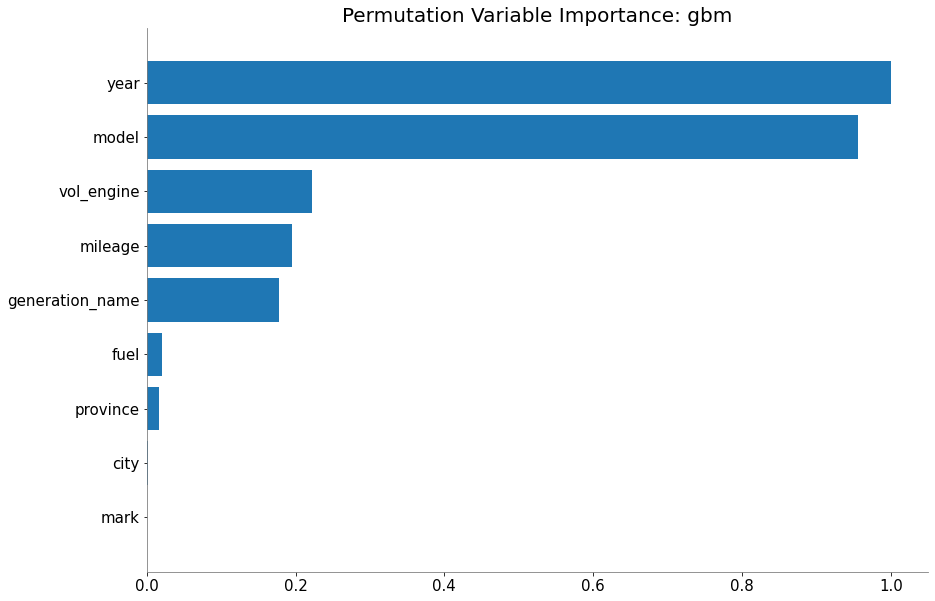


Variable Importances: 


,Variable,Relative Importance,Scaled Importance,Percentage
0,year,50542.719583,1.000000,0.385873
1,model,48343.776735,0.956493,0.369085
2,vol_engine,11230.750448,0.222203,0.085742
3,mileage,9853.538435,0.194955,0.075228
4,generation_name,8976.189427,0.177596,0.068529
5,fuel,1053.706864,0.020848,0.008045
6,province,856.443978,0.016945,0.006539
7,city,120.129832,0.002377,0.000917
8,mark,5.675273,0.000112,0.000043


In [11]:
# plot permutation importance (bar plot)
gbm_model.permutation_importance_plot(test)

## Question 3

Calculate absolute error percentage of the price on test dataset. Add absolute error column to the dataset and call it `abs_error`.   

Formula: `abs(price-predict_price)`

In [12]:
yhat = 'predicted_price'
resid = 'r_price'
preds1 = gbm_model.predict(test)
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])
test_yhat['abs_error'] = abs(test_yhat['price'] - test_yhat['predicted_price'])
Question_6=h2o.deep_copy(test_yhat,'Question_6')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [13]:
### added the abs_error and simply did difference as the response variable is a continuous variable.

In [14]:
test_yhat

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,predicted_price,abs_error
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,SzamotuÅ‚y,Wielkopolskie,49500,53538,4038.03
ford,mustang,,1967,1,6384,Gasoline,Å�Ã³dÅº,Å�Ã³dzkie,379900,190373,189527
mini,cooper,,2016,125600,1998,Gasoline,PoznaÅ„,Wielkopolskie,99800,73608.9,26191.1
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,RadziejÃ³w,Kujawsko-pomorskie,59900,80621.7,20721.7
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,56999,51826.2,5172.81
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Åšwiebodzice,DolnoÅ›lÄ…skie,13900,11438.1,2461.94
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,SwarzÄ™dz,Wielkopolskie,117500,109893,7606.91
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,59900,155633,95733.4
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,160000,137626,22373.8
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Å�Ã³dÅº,Å�Ã³dzkie,140046,150681,10635.5


## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Based on the Summary plot, how features `year` and `mileage` affect model precition of the car price?  

### According to the Shapley values, year is the most important feature. 

### Based on the summary plot, year and mileage behave as expected
### New cars impact it positively and older cars impact the values negatively.
### for mileage it's vice versa. More miles would lower the value and less miles would increase it.

In [15]:
def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    
    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=0.2
                            )

In [16]:
yhat = 'predicted_price'
resid = 'r_price'
preds1 = gbm_model.predict(test)
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])
test_yhat['abs_error'] = abs(test_yhat['price'] - test_yhat['predicted_price'])
Question_6=h2o.deep_copy(test_yhat,'Question_6')

def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    
    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=0.2
                            )

shap_contribs = gbm_model.predict_contributions(test)
df = shap_contribs.as_data_frame(use_pandas=True)
print("Sum Absolute Shapley values for:")
print("year:",df["year"].abs().sum().round(0))
print("mileage:",df["mileage"].abs().sum().round(0))

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
Sum Absolute Shapley values for:
year: 978145348.0
mileage: 245497737.0


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


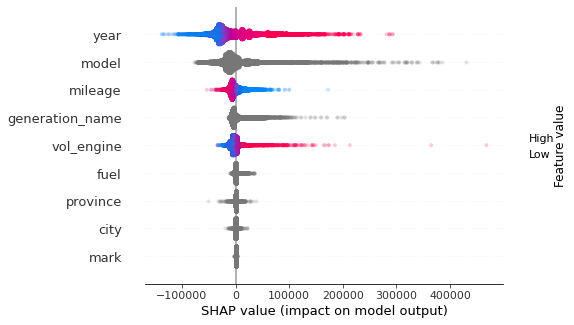

## Question 5

Plot individual Shapley values plots for records top 3 and bottom 3 records based on the residuals, for the total of 6 plots.  

Explain each plot in terms of what are most influential features and how they impact model prediction, and why you think model was correct for the top 3 records (smallest residuals) and significantly incorrect for the bottom 3 records (largest residuals).


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [35]:
test_yhat2[['abs_error']]

,abs_error
0,0.290969
1,0.389796
2,0.671053
3,0.732087
4,1.381015
...,...
29477,364782.472422
29478,436145.738457
29479,516661.698472
29480,541164.734986


In [20]:
# Taken from lecture Mod 8 NB
import shap 
shap.initjs()
def examine_indiv_reason_codes(df_vals_and_cotribs,
                               rec_num, 
                               include_columns, 
                               contrib_columns,
                               use_matplotlib=False):
    
    shap_columns = contrib_columns.copy()
    shap_columns.remove("BiasTerm")
    ftr_columns = include_columns.copy()
    ftr_columns.remove("price")
    bias = df_vals_and_cotribs['BiasTerm'].iloc[rec_num]
    shap_contribs = df_vals_and_cotribs[shap_columns].iloc[rec_num,:].values
    ftr_values =    df_vals_and_cotribs[ftr_columns].iloc[rec_num,:].values
    
    return shap.force_plot(bias, 
                           shap_contribs, 
                           ftr_values, 
                           shap_columns,
                           link="logit",
                           matplotlib=use_matplotlib)

## Top 3

In [36]:
examine_indiv_reason_codes(test_yhat2,0,include_columns,contrib_columns)

### For this observation, the vol_engine has a slight positive effect while year,model,and mileage and a large effect that gets 
#### Progressively smaller but negative nonetheless. It makes sense as these 3 were in the top feature importance.

In [37]:
examine_indiv_reason_codes(test_yhat2,1,include_columns,contrib_columns)
## Similarily, this record also has year with the largest negative effect followed by model. The vol_engine has a smaller volume 
#so it results in having a negative effect. The generation name would be correlated with the model and the mileage is
## again in the top importance values.

In [38]:
examine_indiv_reason_codes(test_yhat2,2,include_columns,contrib_columns)
### Like the other two this record also has year with the largest negative effect followed by model. The vol_engine has a smaller volume 
#so it results in having a negative effect. The generation name would be correlated with the model and the mileage is
## again in the top importance values.

## Bottom 3

In [39]:
examine_indiv_reason_codes(test_yhat2,29479,include_columns,contrib_columns)
### This third from the bottom record is incorrecte as the highest postive effect comes from Vol_engine and even mileage has a 
### positive effect. However, the vol engine was not in the top important features either so the great effect wouldn't make sense.

In [40]:
examine_indiv_reason_codes(test_yhat2,29480,include_columns,contrib_columns)
### Same for this record, sencond from last, it has vol engine giving a larger positive effect
### with year giving the smallest effect. 

In [41]:
examine_indiv_reason_codes(test_yhat2,29481,include_columns,contrib_columns)
### This record would be off as well,mileage is seen to have a positive effect although it is small,
### But it also had a greater importance than vol engine and generation name. year and model are consistent in terms of 
### size.

## Question 6 

Train new H2O GBM model on the test dataset trying to predict residuals. This is your surrogate modedel that you will use to understand what features are driving high residuals.   

Use same parameters as in question #1, except:
  - predictor is now "abs_error"
  - dataset now is "test" dataset
  - make sure not to include original "price" column in the model

Plot Shapley summary plot for the top 100 records with highest residuals.
Answer following question:
  - What is the most important feature of the surrogate model that impacts high residuals?

In [ ]:
### Once we plot the surrogate model, we can see that model is the most important feature.

In [27]:
yhat = 'predicted_price'
resid = 'r_price'
preds1 = gbm_model.predict(test)
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])
test_yhat['abs_error'] = abs(test_yhat['price'] - test_yhat['predicted_price'])
Question_6=h2o.deep_copy(test_yhat,'Question_6')

def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    
    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=0.2
                            )

shap_contribs = gbm_model.predict_contributions(test)
df = shap_contribs.as_data_frame(use_pandas=True)
print("Sum Absolute Shapley values for:")
print("year:",df["year"].abs().sum().round(0))
print("mileage:",df["mileage"].abs().sum().round(0))

examine_all_reason_codes(test, gbm_model)

pred_contributions_orig_table = gbm_model.predict_contributions(test)
contrib_columns = []
for col in test.columns:
    if col not in ['BiasTerm', response, 'price', 'predicted_price', 'abs_error']:
        contrib_columns.append("contrib_"+col)

contrib_columns.append('BiasTerm')
pred_contributions_orig_table.columns = contrib_columns

test_yhat2 = test_yhat.cbind(pred_contributions_orig_table)

include_columns = test.columns
test_yhat2 = test_yhat2.as_data_frame()
test_yhat2 = test_yhat2.sort_values(by='abs_error', ascending=True).reset_index(drop=True)

from h2o.estimators import H2OGradientBoostingEstimator

response = "abs_error"

Question_6=h2o.deep_copy(test_yhat,'Question_6')
Question_6= Question_6.drop('price')
Question_6= Question_6.drop('predicted_price')
predictors_gbm = Question_6.columns



gbm_model_surrogate = H2OGradientBoostingEstimator(nfolds=5,
                                                   ntrees=500,
                                                   stopping_rounds=5,
                                                   stopping_metric='MAE',
                                                   seed=1234,
                                                   keep_cross_validation_predictions = False)

gbm_model_surrogate.train(x=predictors_gbm, y=response, training_frame=Question_6)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1651554215654_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,38.0,38.0,29821.0,5.0,5.0,5.0,8.0,30.0,21.447369




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 109085271.21380475
RMSE: 10444.389461036233
MAE: 4920.427112181866
RMSLE: NaN
Mean Residual Deviance: 109085271.21380475

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 175337558.54317215
RMSE: 13241.508922444305
MAE: 5453.79751843003
RMSLE: NaN
Mean Residual Deviance: 175337558.54317215

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,5.455088e+03,5.132165e+01,5.502070e+03,5.467940e+03,5.426710e+03,5.380781e+03,5.497940e+03
1,mean_residual_deviance,1.756632e+08,2.078986e+07,1.856794e+08,1.744127e+08,1.528065e+08,1.602889e+08,2.051282e+08
2,mse,1.756632e+08,2.078986e+07,1.856794e+08,1.744127e+08,1.528065e+08,1.602889e+08,2.051282e+08
3,r2,3.637466e-01,3.489438e-02,3.322074e-01,3.778483e-01,4.041808e-01,3.820603e-01,3.224360e-01
4,residual_deviance,1.756632e+08,2.078986e+07,1.856794e+08,1.744127e+08,1.528065e+08,1.602889e+08,2.051282e+08
5,rmse,1.323546e+04,7.793063e+02,1.362642e+04,1.320654e+04,1.236149e+04,1.266052e+04,1.432230e+04
6,rmsle,1.242919e+00,1.203551e-02,1.256521e+00,1.239149e+00,1.228333e+00,NaN,1.247671e+00



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-05-03 00:04:47,2.265 sec,0.0,16593.732087,7939.171732,2.753519e+08
1,,2022-05-03 00:04:47,2.282 sec,1.0,15914.199492,7526.383979,2.532617e+08
2,,2022-05-03 00:04:47,2.294 sec,2.0,15324.645253,7174.808441,2.348448e+08
3,,2022-05-03 00:04:47,2.305 sec,3.0,14823.861912,6881.214252,2.197469e+08
4,,2022-05-03 00:04:47,2.318 sec,4.0,14392.347818,6633.841328,2.071397e+08
5,,2022-05-03 00:04:47,2.330 sec,5.0,14002.508867,6420.213813,1.960703e+08
6,,2022-05-03 00:04:47,2.339 sec,6.0,13631.222573,6233.738016,1.858102e+08
7,,2022-05-03 00:04:47,2.350 sec,7.0,13339.474660,6079.984909,1.779416e+08
8,,2022-05-03 00:04:47,2.366 sec,8.0,13075.172276,5944.352259,1.709601e+08
9,,2022-05-03 00:04:47,2.379 sec,9.0,12831.429535,5824.242833,1.646456e+08



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,model,1.028442e+13,1.000000,0.398691
1,generation_name,5.016993e+12,0.487825,0.194491
2,year,3.591053e+12,0.349174,0.139213
3,vol_engine,2.762971e+12,0.268656,0.107111
4,mileage,2.347466e+12,0.228255,0.091003
5,province,1.089757e+12,0.105962,0.042246
6,city,5.716332e+11,0.055582,0.022160
7,fuel,1.273837e+11,0.012386,0.004938
8,mark,3.787043e+09,0.000368,0.000147


In [28]:
yhat= 'predicted_abs_error'
resid = 'r_abs_error'
preds1 = gbm_model_surrogate.predict(Question_6)
preds1.columns = [yhat]
test_yhat = Question_6.cbind(preds1[yhat])
test_yhat['abs_error_surrogate'] = abs(test_yhat['abs_error'] - test_yhat['predicted_abs_error'])
test_yhat.describe

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,abs_error,predicted_abs_error,abs_error_surrogate
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,SzamotuÅ‚y,Wielkopolskie,4038.03,7616.76,3578.72
ford,mustang,,1967,1,6384,Gasoline,Å�Ã³dÅº,Å�Ã³dzkie,189527,189704,176.943
mini,cooper,,2016,125600,1998,Gasoline,PoznaÅ„,Wielkopolskie,26191.1,11196.1,14995
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,RadziejÃ³w,Kujawsko-pomorskie,20721.7,8650.23,12071.5
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,5172.81,5975.21,802.403
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Åšwiebodzice,DolnoÅ›lÄ…skie,2461.94,3514.86,1052.93
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,SwarzÄ™dz,Wielkopolskie,7606.91,11901.9,4294.98
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,95733.4,65185.9,30547.5
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,22373.8,13178.7,9195.11
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Å�Ã³dÅº,Å�Ã³dzkie,10635.5,22699.7,12064.3


<bound method H2OFrame.describe of >

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


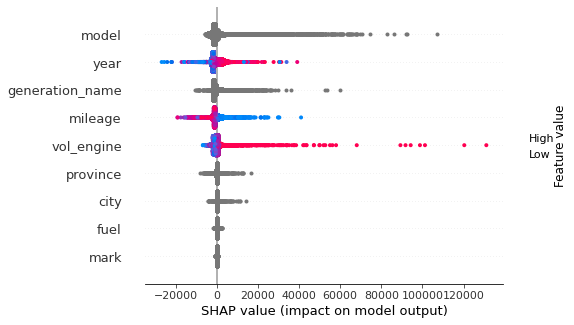

In [29]:
pred_contributions_orig_table = gbm_model_surrogate.predict_contributions(test_yhat)

contrib_columns = []
for col in test_yhat.columns:
    if col not in ['BiasTerm',"abs_error", "predicted_abs_error","predicted_price","price", "abs_error_surrogate"]:
        contrib_columns.append("contrib_"+col)
        
contrib_columns.append('BiasTerm')
pred_contributions_orig_table.columns = contrib_columns
test_yhat = test_yhat.cbind(pred_contributions_orig_table)
test_yhat = test_yhat.as_data_frame()

shap_columns = contrib_columns.copy()
ftr_columns = include_columns.copy()
ftr_columns.remove("price")
shap_columns.remove("BiasTerm")
bias = test_yhat['BiasTerm'].iloc[0]
shap_contribs = test_yhat[shap_columns].values
ftr_values =    test_yhat[ftr_columns]

shap.summary_plot(shap_values=shap_contribs,
                  features=ftr_values)

In [30]:
test_yhat = test_yhat.sort_values(by='abs_error_surrogate', ascending=False).reset_index(drop=True)
test_yhat.head(3)

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,abs_error,...,contrib_mark,contrib_model,contrib_generation_name,contrib_year,contrib_mileage,contrib_vol_engine,contrib_fuel,contrib_city,contrib_province,BiasTerm
0,mercedes-benz,s-klasa,gen-w223-2020,2021,9000,2999,Gasoline,Sosnowiec,ÅšlÄ…skie,676466.654574,...,-1.229302,86307.976562,52538.992188,27658.513672,41006.312500,34130.730469,812.136047,10508.232422,12246.663086,8277.501953
1,bmw,x7,NaN,2021,17500,2993,Diesel,Bielsko-BiaÅ‚a,ÅšlÄ…skie,436145.738457,...,1.229302,48749.703125,-1636.061646,12940.287109,21706.595703,6073.693848,-32.695343,14121.699219,6853.995117,8277.501953
2,bmw,seria-7,gen-g11-12-2015,2021,1,2993,Diesel,Stare Miasto,Wielkopolskie,338832.855749,...,1.229302,45914.988281,-2695.118652,9148.015625,11559.031250,9605.121094,-718.816895,466.357727,4281.991211,8277.501953


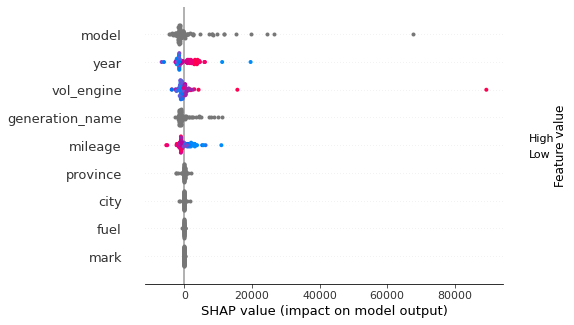

In [31]:
shap.summary_plot(shap_values=shap_contribs[0:99],
                  features=ftr_values[0:99])